# So, You Want to Get into Movies?

- Mohammad Abou-Ghazala
- **Instructor:** Mark Barbour

## 1. Overview


My company wishes to step into the movie-making business, and as a newcomer, it wants insight into which movies are currently performing the best and recommendations as to which types of movies to create. I work with datasets from IMDB and Box Office Mojo to learn which movies perform the best at the box office, and which movies are best received among audiences and critics. As a result, I'm able to recommend 10 genres of movies to start creating.

## 2. Business Problem

As the COVID-19 pandemic has more or less subsided, it left an indelible mark on the movie theater world, particularly with regards to the role of streaming platforms. A movie's success can no longer just be measured in terms of profits generated at the box office, as movies often are released straight to streaming platforms or in conjunction with a theatrical release, in addition to the fact that movies will often receive a "second life" upon its release on streaming. 

With this context in mind, we should attempt to answer the following questions:
1. Which movies tend to perform the best in terms of gross?
2. Which movies are well-received by audiences and thus more likely to be in demand by streaming platforms?

## 3. Data Understanding

`IMDB` is considered an essential source for data on movies, their reception, and performance, as it contains basic information on a movie's production as well as crowd-sourced user reviews. The IMDB dataset I use is an SQL file with two tables of particular interest:
- `movie_ratings` containing information such as number of votes and the average rating for each film
- `movie_basics` containing basic information such as a movie's release data, genres, and runtime

There are three factors here that are of interest to us:
1. `Genres` which can tell us which types of movies are received well, generally speaking
2. `Average Rating` which tells us which movies were generally well-received by audiences and critics
3. `Number of Votes` which tell us how many individuals gave ratings for a movie, whether good or bad

The issue to keep an eye on for our purposes is that this dataset contains information on all kinds of movies, including lesser known titles that may have had a negligible performance at the box office but still garnered a niche cult following, for example. In essence, these factors will help us to determine which types of films are more likely to reach a wider audience (represented by `Number of Votes`) and which are best received critically (`Average Rating`), both of which can determine a movie's demand among streaming platforms following theatrical release.

What is also worthy of note is that the vast majority of films listed include a wide variety of genre combinations, with an estimated count of combinations in the tens of thousands. Of course it will be much more difficult to analyze genres based on these unique combinations, so instead we need to look at which genres appear the most within those combinations among the best performing movies.

The other dataset I rely on, `Box Office Mojo`, contains data on a movie's domestic and foreign gross. This dataset is more limited, containing information for just a few thousand compared to `IMDB`'s tens of thousands. Nonetheless, we can use the Box Office data to reinforce our analysis as to which movies perform best in theaters if we combine the two datasets based on which movies appear in both.

## 4. Data Preparation

We begin by importing the necessary libraries to load the SQL files for IMDB. As mentioned above, we are interested primarily in two tables: `movie_basics` and `movie_ratings.` We will join these two tables on their shared column, `movie_id`.

In [1]:
#importing libraries

import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import zipfile
with zipfile.ZipFile('im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

/var/folders/kc/5d_pp5b57l9cv1n38nnw2p7r0000gn/T/ipykernel_4929/2977640863.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#establishing the connection

conn = sqlite3.connect('im.db')
cur = conn.cursor()

In [3]:
#loading the SQL directory containing some of the metadata regarding all the tables within the SQL file

pd.read_sql("""
SELECT * 
FROM sqlite_schema
WHERE type='table'
""", conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


### 4.a. Merging `movie_basics` and `movie_ratings` into single dataframe

In [4]:
#joining the two tables on the shared column of `movie_ratings`
imdb_movie_ratings = pd.read_sql("""
SELECT * FROM movie_basics
LEFT JOIN movie_ratings
USING(movie_id)
""", conn)

In [5]:
imdb_movie_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [6]:
# Checking for the amount of null values

imdb_movie_ratings.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
averagerating      72288
numvotes           72288
dtype: int64

In [7]:
# Calculating the proportion of null values per row

imdb_movie_ratings.isna().sum()/len(imdb_movie_ratings)

movie_id           0.000000
primary_title      0.000000
original_title     0.000144
start_year         0.000000
runtime_minutes    0.217176
genres             0.037005
averagerating      0.494635
numvotes           0.494635
dtype: float64

**`averagerating` and `numvotes` have a relatively high proportion of null values**

Let's take a look at the entries with null `averagerating` and `numvotes`

In [8]:
null_imdb_movie_ratings = imdb_movie_ratings[
    imdb_movie_ratings['numvotes'].isna()
]

null_imdb_movie_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,NaN,NaN
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History",NaN,NaN
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography,NaN,NaN
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None,NaN,NaN
25,tt0262759,Seven Jews from My Class,Siedmiu Zydów z mojej klasy,2018,40.0,Documentary,NaN,NaN


In [9]:
print(f" There are {len(null_imdb_movie_ratings['movie_id'])} movies with null Ratings and Votes")
print(f" out of {len(imdb_movie_ratings['movie_id'])} total movies")

 There are 72288 movies with null Ratings and Votes
 out of 146144 total movies


#### We will remove the entries with no Ratings or Votes from the dataset

This will still leave us with more than 70,000 movies to work with

In [10]:
imdb_movie_ratings.dropna(subset=['numvotes'], inplace=True)

In [11]:
# Confirming that this worked for both averagerating column and numvotes column

print('Total null ratings:', imdb_movie_ratings['averagerating'].isna().sum())

print('Total null votes:', imdb_movie_ratings['numvotes'].isna().sum())

Total null ratings: 0
Total null votes: 0


### 4.b. Dealing with duplicate entries

First we'll check for the number of movies with the same name.

In [12]:
print(f" There are {imdb_movie_ratings.duplicated(subset=['primary_title']).sum()} movies with the same title.")

 There are 3863 movies with the same title.


With close to 4,000 movies sharing a title, let's see which ones also share a runtime and year to confirm they are indeed the same movie.

In [13]:
print(
    f"There are {imdb_movie_ratings.duplicated(subset=['primary_title','runtime_minutes', 'start_year']).sum()} "
    f" duplicates of the same movie.")
    

There are 25  duplicates of the same movie.


While 25 movie duplicates is not too many, let's drop them for clarity's sake. Let's keep the entry with the higher number of votes.

In [14]:
# Ordering the dataset by the number of votes

imdb_movie_ratings.sort_values(
    by='numvotes',
    ascending=False,
    inplace=True)

In [15]:
# Dropping the duplicate movies with the lower count of votes

imdb_movie_ratings.drop_duplicates(
    subset=['primary_title', 'runtime_minutes', 'start_year'],
    inplace=True,
    keep='first')

In [16]:
imdb_movie_ratings.duplicated(subset=['primary_title', 'runtime_minutes', 'start_year']).sum()

0

### 4.c. Dealing with the `genres` column

There are about 800 movies with null entries in the `genres` column, or just over 1%.


In [17]:
imdb_movie_ratings.isna().sum()/len(imdb_movie_ratings)

movie_id           0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
runtime_minutes    0.103141
genres             0.010890
averagerating      0.000000
numvotes           0.000000
dtype: float64

In [18]:
imdb_movie_ratings.dropna(subset=['genres'], inplace=True)

In [19]:
imdb_movie_ratings['genres'].isna().sum()

0

**Furthermore, many movies have the multiple entries in the `genres` column, which would make analyzing the genres difficult.**

As it stands, there are more than 146,000 unique categories for genres due to errors in formatting and unique combinations.

In [20]:
imdb_movie_ratings['genres'].unique

<bound method Series.unique of 7066      Action,Adventure,Sci-Fi
6900              Action,Thriller
311        Adventure,Drama,Sci-Fi
20342               Drama,Western
356       Action,Adventure,Sci-Fi
                   ...           
92160                       Drama
111768                      Drama
21592                 Documentary
12580                    Thriller
104100                Documentary
Name: genres, Length: 73027, dtype: object>

First, let's correct the formatting by splitting the entries by the commas. This will also convert the multiple genre entries into a list.\
I'll create a new dataframe for this in case `imdb_movie_ratings` is useful for further analysis later.

In [21]:
# Creating a copy 

imdb_clean_genres = imdb_movie_ratings.copy()

In [22]:
# Using `str.split()` to separate the genre entries and convert them into a list

imdb_clean_genres['genres'] = imdb_clean_genres['genres'].str.split(',')

In [23]:
imdb_clean_genres.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"[Action, Adventure, Sci-Fi]",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"[Action, Thriller]",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"[Adventure, Drama, Sci-Fi]",8.6,1299334.0
20342,tt1853728,Django Unchained,Django Unchained,2012,165.0,"[Drama, Western]",8.4,1211405.0
356,tt0848228,The Avengers,The Avengers,2012,143.0,"[Action, Adventure, Sci-Fi]",8.1,1183655.0


Let's get a count of all the unique individual genres listed across the dataset, using a for-loop.

In [24]:
genres = set()
genres_col = imdb_clean_genres['genres']

for entries in genres_col:
    for genre in entries:
        genres.add(genre)

In [25]:
print(
    f" There are {len(genres)} unique genres in our data set.\n\n" 
    f" These genres are: \n"
    f"{genres}")

 There are 26 unique genres in our data set.

 These genres are: 
{'Fantasy', 'Music', 'Thriller', 'Reality-TV', 'Adult', 'Sport', 'Western', 'Sci-Fi', 'News', 'Biography', 'Documentary', 'Horror', 'Musical', 'Game-Show', 'Family', 'History', 'War', 'Adventure', 'Drama', 'Crime', 'Romance', 'Mystery', 'Action', 'Animation', 'Comedy', 'Short'}


#### Creating a new dataset with separated entries under `genres`

I will do this using `.explode()` which will separate each genre into a new row.

In [26]:
imdb_expl_genres = imdb_clean_genres.explode('genres')

In [27]:
imdb_expl_genres.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,Action,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Adventure,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Sci-Fi,8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Action,8.4,1387769.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Thriller,8.4,1387769.0


In [28]:
imdb_expl_genres['genres'].value_counts()

genres
Drama          30782
Documentary    17747
Comedy         17286
Thriller        8212
Horror          7672
Action          6986
Romance         6584
Crime           4610
Adventure       3816
Biography       3806
Family          3411
Mystery         3038
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1967
Animation       1742
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: count, dtype: int64

#### Removing outliers and potential noise

As we can see above, the bottom four genres of `Reality-TV`, `Adult`, `Game-Show`, and `Short` all have much lower counts, which could potentially pollute any visualizations or analysis of the relation between the genre with other metrics.

In [29]:
# First, let's collect the `movie_id` for all the movies falling under these noisy genres
noisy_genre_titles = (
    imdb_expl_genres[imdb_expl_genres['genres'].isin([
        'Reality-TV', 'Adult', 'Game-Show', 'Short'])]['movie_id'])

# Checking that it worked

len(noisy_genre_titles)

23

Now, let's use a for-loop to remove these titles from all of the datasets we've created so far so we don't have to repeat this process


In [30]:
for df in [imdb_expl_genres, imdb_movie_ratings, imdb_clean_genres]:
    df.drop(df[df['movie_id'].isin(noisy_genre_titles)].index, inplace=True)

In [31]:
# Checking to see if it worked

imdb_expl_genres['genres'].value_counts()

genres
Drama          30777
Documentary    17737
Comedy         17282
Thriller        8211
Horror          7671
Action          6984
Romance         6584
Crime           4610
Adventure       3814
Biography       3805
Family          3411
Mystery         3038
History         2824
Sci-Fi          2206
Fantasy         2126
Music           1966
Animation       1742
Sport           1179
War              853
Musical          721
News             578
Western          280
Name: count, dtype: int64

### 4.d. Factoring in Domestic and Foreign Gross

Now that we have cleaned up the dataset from IMDB according to `averagerating`, `numvotes`, and `genres`, let's see if we can pull in data regarding the how well movies grossed domestically and internationally.

We will pull a dataset from `Box Office Mojo`, which ia affiliated with IMDB and tracks domestic and foreign gross for movies.

It's important to note that the data is inconsistent with the movies contained in the IMDB datasets we've looked at so far: not all movies in these datasets have information on gross performance. Regardless, we may be able to gain insights by looking at which films performed well at the box office.

In [32]:
# Loading in the box office dataset

box_office_df = pd.read_csv('bom.movie_gross.csv.gz')
box_office_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [33]:
box_office_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


So we have about 3,400 movies listed in this dataset, which is far less than the 70,000+ movies we've been working with in the above datasets.

We also have two separate columns for `domestic_gross` and `foreign_gross` with many movies having null entries.

In [34]:
box_office_df.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

This is understandable for `foreign_gross` as it may be more difficult to ascertain the gross in foreign markets than the domestic one. However, as domestic gross is a primary factor to consider we will need to remove entries with null entries under `domestic_gross`.

In [35]:
box_office_clean = box_office_df.dropna(subset=['domestic_gross'])
box_office_clean['domestic_gross'].isna().sum()

0

Seeing how there are so many null values under `foreign_gross`, we will replace those values with 0 and turn the data from both this column and `domestic_gross` into integers.

In [36]:
box_office_clean.loc[:, 'foreign_gross'] = box_office_clean['foreign_gross'].fillna(0)

# filtering out unnecessary warnings from Jupyter Notebook
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [37]:
box_office_clean['foreign_gross'].isna().sum()

0

In [38]:
box_office_clean[['domestic_gross', 'foreign_gross']] = (
    box_office_clean[['domestic_gross', 'foreign_gross']]
    .replace({",": ""}, regex=True)
    .apply(pd.to_numeric, errors='coerce')
    .astype(int))

In [39]:
box_office_clean.dtypes

title             object
studio            object
domestic_gross     int64
foreign_gross      int64
year               int64
dtype: object

Now that we have cleaned the dataset to remove null values for domestic gross and replace null values in foreign gross with 0, we will create a new column `total_gross` representing the sum of both domestic and foreign gross.

In [40]:
box_office_clean['total_gross'] = box_office_clean['domestic_gross'] + box_office_clean['foreign_gross']

In [41]:
# Reordering the columns for easier reading
box_office_clean = box_office_clean[[
    'title', 'studio', 'year', 'domestic_gross', 'foreign_gross', 'total_gross']]

In [42]:
box_office_clean

,title,studio,year,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,BV,2010,415000000,652000000,1067000000
1,Alice in Wonderland (2010),BV,2010,334200000,691300000,1025500000
2,Harry Potter and the Deathly Hallows Part 1,WB,2010,296000000,664300000,960300000
3,Inception,WB,2010,292600000,535700000,828300000
4,Shrek Forever After,P/DW,2010,238700000,513900000,752600000
...,...,...,...,...,...,...
3382,The Quake,Magn.,2018,6200,0,6200
3383,Edward II (2018 re-release),FM,2018,4800,0,4800
3384,El Pacto,Sony,2018,2500,0,2500
3385,The Swan,Synergetic,2018,2400,0,2400


### 4.f. Creating new dataframe with both Ratings and Gross factors

To look into the relationship between how well a movie does at the box office and how well the movie is received, we will create a new dataset that pulls together data for the following cetagories:

1. `domestic_gross`
2. `foreign_gross`
3. `total_gross`
4. `averagerating`
5. `numvotes`
6. `genres`

Since there are far fewer entries listed for the Gross factors, this dataset will be more limited since we can only include movies that are present in both the **imdb_expl_genres** dataset as well as the **box_office_clean** dataset.

First, we need to change the `primary_title` column in the **imdb_expl_genres** dataset to match with the **box_office_clean** dataset.

In [43]:
# renaming `primary_title` column
imdb_expl_genres = imdb_expl_genres.rename(columns={'primary_title': 'title'})

In [44]:
movies_ratings_gross = pd.merge(
    imdb_expl_genres[['movie_id', 'title', 'runtime_minutes', 'genres', 'averagerating', 'numvotes']],
    box_office_clean[['title', 'domestic_gross', 'foreign_gross', 'total_gross']],
    on='title')
    

In [45]:
movies_ratings_gross.head()

,movie_id,title,runtime_minutes,genres,averagerating,numvotes,domestic_gross,foreign_gross,total_gross
0,tt1375666,Inception,148.0,Action,8.8,1841066.0,292600000,535700000,828300000
1,tt1375666,Inception,148.0,Adventure,8.8,1841066.0,292600000,535700000,828300000
2,tt1375666,Inception,148.0,Sci-Fi,8.8,1841066.0,292600000,535700000,828300000
3,tt1345836,The Dark Knight Rises,164.0,Action,8.4,1387769.0,448100000,636800000,1084900000
4,tt1345836,The Dark Knight Rises,164.0,Thriller,8.4,1387769.0,448100000,636800000,1084900000


In [46]:
movies_ratings_gross.info

<bound method DataFrame.info of        movie_id                       title  runtime_minutes       genres  \
0     tt1375666                   Inception            148.0       Action   
1     tt1375666                   Inception            148.0    Adventure   
2     tt1375666                   Inception            148.0       Sci-Fi   
3     tt1345836       The Dark Knight Rises            164.0       Action   
4     tt1345836       The Dark Knight Rises            164.0     Thriller   
...         ...                         ...              ...          ...   
6920  tt4540326                      Buried             95.0     Thriller   
6921  tt2201884                The Workshop             77.0  Documentary   
6922  tt2201884                The Workshop             77.0       Family   
6923  tt3604256                       Split              NaN        Crime   
6924  tt3566920  The Other Side of the Door             90.0        Drama   

      averagerating   numvotes  domestic_gr

Now that we have our datasets ready and cleaned, we will save them in case we need to use outside software, such as Tableau, to assist with visualizations.

In [47]:
movies_ratings_gross.to_csv('movies_ratings_gross.csv')
imdb_movie_ratings.to_csv('imdb_ratings.csv')
imdb_expl_genres.to_csv('imdb_genres_ratings.csv')
box_office_clean.to_csv('box_office_clean.csv')

## 5. Modeling

With the datasets prepared and ready, we can start to look at how the data is distributed and produce visualizations to provide more insight into the significance of the factors outlined above (`Vote Count`, `Average Rating`, `Total Gross`, `Genres`).

In [48]:
# importing libraries

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

warnings.filterwarnings('ignore', category=FutureWarning)

plt.rcdefaults()
plt.style.use('seaborn-v0_8-darkgrid')

In [49]:
movies_ratings_gross.shape

(6925, 9)

In [50]:
# looking at the average Vote Count

movies_ratings_gross['numvotes'].mean()

72596.65155234656

### 5.a. Looking at distribution of `Vote Count`, `Average Rating`, `Genres`

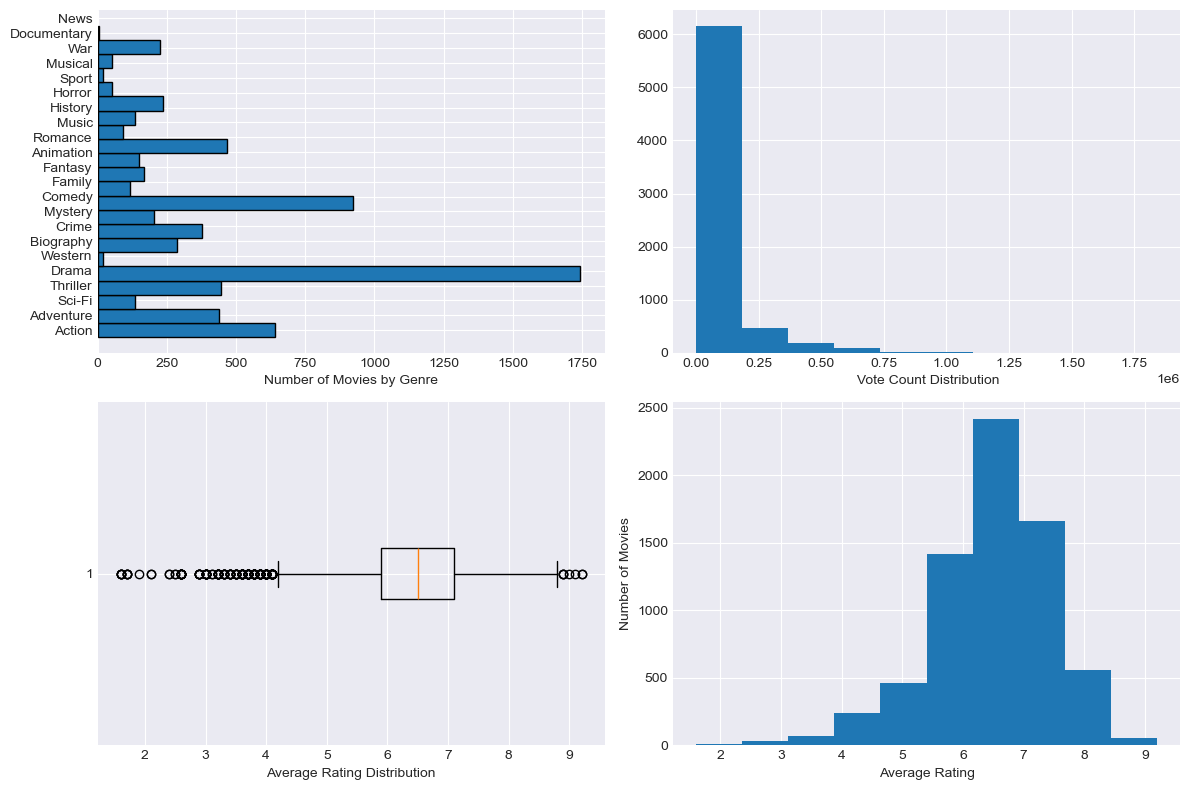

In [51]:
fig, ((genre_hist, vote_hist), (rating_box, rating_hist)) = plt.subplots(
    nrows=2, ncols=2, 
    figsize=(12,8))

# Top Row
genre_hist.hist(movies_ratings_gross['genres'], bins=22, align='left', orientation='horizontal', edgecolor='black')
genre_hist.set_xlabel('Number of Movies by Genre')

vote_hist.hist(movies_ratings_gross['numvotes'])
vote_hist.set_xlabel(' Vote Count Distribution')

# Bottom Row
rating_box.boxplot(movies_ratings_gross['averagerating'], vert=False)
rating_box.set_xlabel('Average Rating Distribution')

rating_hist.hist(movies_ratings_gross['averagerating'], orientation='vertical')
rating_hist.set_xlabel('Average Rating')
rating_hist.set_ylabel('Number of Movies')




plt.tight_layout();

**We can see that the Vote Counts are heavily skewed to the left, indicating a high quantity of films with low Vote Counts.**

This could potentially pollute our analysis, as we are looking to analyze the films with the highest viewership and vote count.

Let's look at some data around the vote counts.

In [52]:
votes_mean = round(movies_ratings_gross['numvotes'].mean(), 2)
votes_median = movies_ratings_gross['numvotes'].median()
votes_q75 = movies_ratings_gross['numvotes'].quantile(.75)

print(f" The average number of votes is: {votes_mean}")
print(f" The median vote count is: {votes_median}")
print(f" The number of movies in the bottom 75% in terms of vote count is: {votes_q75}")


 The average number of votes is: 72596.65
 The median vote count is: 19387.0
 The number of movies in the bottom 75% in terms of vote count is: 79337.0


**To further narrow our analysis, let's remove the titles in the bottom 75% of movies in terms of vote count.** 

Though this is the majority of our data, it was give us a sharper analysis since we will be looking at the movies that gained the most traction and highest audience count.

**We will also create a new dataframe with the bottom 75% of movies in terms of vote count in case it helps us see what movies to avoid.**

In [53]:
# creating new dataframe with the top 25% of movies in terms of vote count

movies_top_25 = movies_ratings_gross[
    movies_ratings_gross['numvotes'] >= votes_q75
]

# creating new dataframe with bottom 75% of movies in terms of vote count

movies_bottom_75 = movies_ratings_gross[
    movies_ratings_gross['numvotes'] <= votes_q75
]

In [54]:
print(movies_top_25.shape)
print(movies_bottom_75.shape)

(1733, 9)
(5194, 9)


**With 1,700 movies left in our new `movies_top_25`, let's see look at the distributions play out now.**

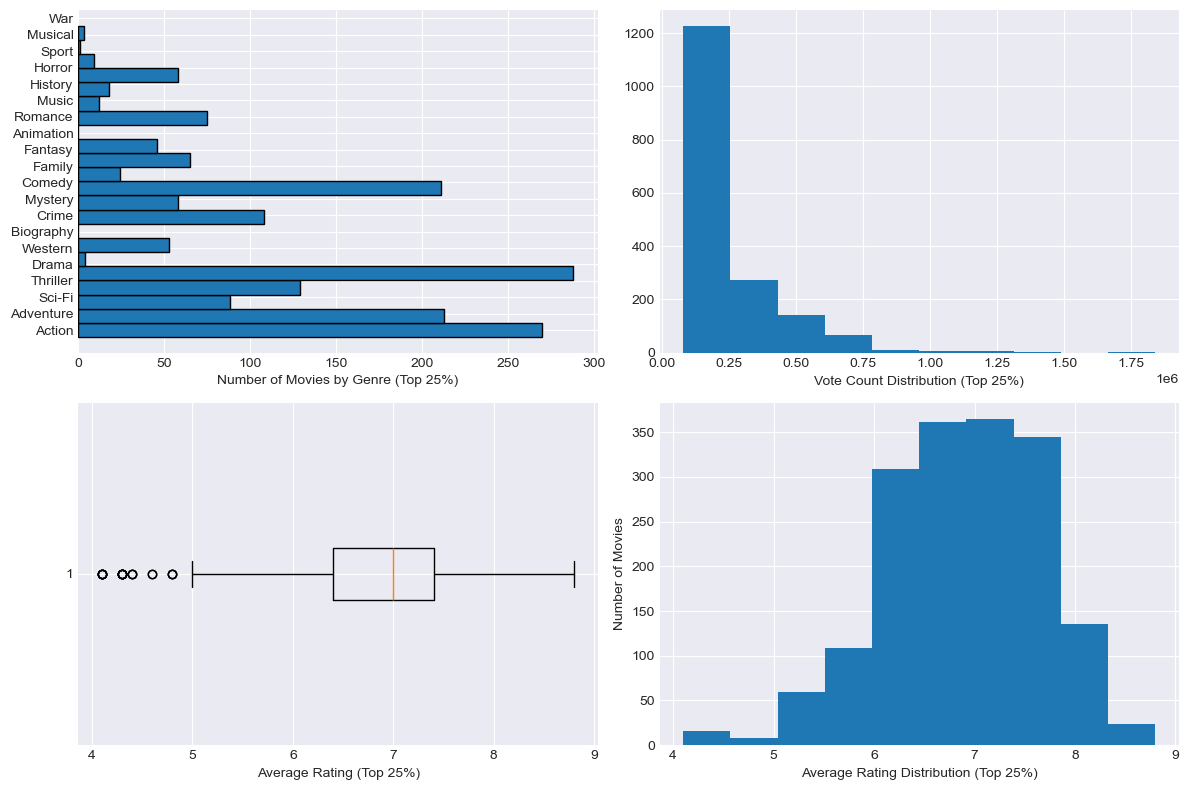

In [57]:
fig, ((genre_hist, vote_hist), (rating_box, rating_hist)) = plt.subplots(
    nrows=2, ncols=2, 
    figsize=(12,8))

# Top Row
genre_hist.hist(movies_top_25['genres'], bins=22, align='left', orientation='horizontal', edgecolor='black')
genre_hist.set_xlabel('Number of Movies by Genre (Top 25%)')

vote_hist.hist(movies_top_25['numvotes'])
vote_hist.set_xlabel('Vote Count Distribution (Top 25%)')

# Bottom Row
rating_box.boxplot(movies_top_25['averagerating'], vert=False)
rating_box.set_xlabel('Average Rating (Top 25%)')

rating_hist.hist(movies_top_25['averagerating'], orientation='vertical')
rating_hist.set_xlabel('Average Rating Distribution (Top 25%)')
rating_hist.set_ylabel('Number of Movies')




plt.tight_layout()

The distribution of the vote count only improved slightly, which is unavaoidable considering the sheer amount of content out there that is being produced.

The average rating shifted slightly to the right, with a higher density around the middle than before.

Most significant is the distribution of genres, with `Drama` dropping significantly and notably higher distributions for `Thriller`, `Action`, and `Comedy`.

Now that we are dealing with the top 25% of movies according to vote count, let's see which genres tend to gross the highest in total.

### 5.b. What is the relationship between `Gross`, `Average Rating`, and `Vote Count`?

Let's further investigate the relationship between the factors of Gross, Average Rating, and Vote Count, and see whether these relationships are statistically significant. We will do this by calculating the **Correlation Coefficient** which can help determine if the strength of the relationship between these factors.

#### Relationship between `Total Gross` and `Vote Count`

In [58]:
# using NumPy to calculate Correlation Coefficient

print('Correlation between number of votes and average total gross: {}'.format(
    np.corrcoef(
        movies_ratings_gross['total_gross'],
        movies_ratings_gross['numvotes'])[0,1]
))

Correlation between number of votes and average total gross: 0.6642204874541286


This suggests a **moderate positive correlation** between total gross and number of votes, which is expected to a degree. Let's see how this relationship plays out on a scatterplot.

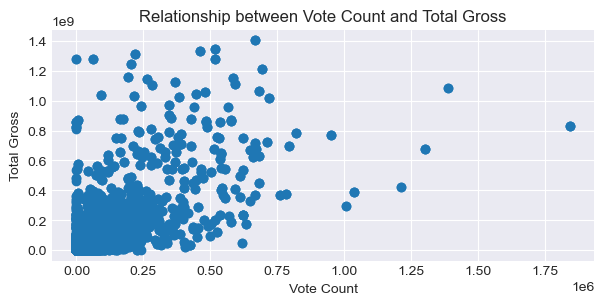

In [59]:
# visualizing the relationship with a scatterplot

fix, ax = plt.subplots(figsize=(7, 3))

ax.scatter(
    x=movies_ratings_gross['numvotes'],
    y=movies_ratings_gross['total_gross'])

ax.set_xlabel('Vote Count')
ax.set_ylabel('Total Gross')
ax.set_title('Relationship between Vote Count and Total Gross');

We can deduce with some certainty that **the higher vote count a movie has, the higher the movie's total gross.**

#### Relationship between `Total Gross` and `Average Rating`

In [60]:
# using NumPy to calculate Correlation Coefficient

print('Correlation between average rating and average total gross: {}'.format(
    np.corrcoef(
        movies_ratings_gross['total_gross'],
        movies_ratings_gross['averagerating'])[0,1]
))

Correlation between average rating and average total gross: 0.1482181472229351


This suggests a **relatively weak positive correlation** between total gross and average rating, essentially telling us that not all movies that make a lot of money are well-received by the audience or critics.

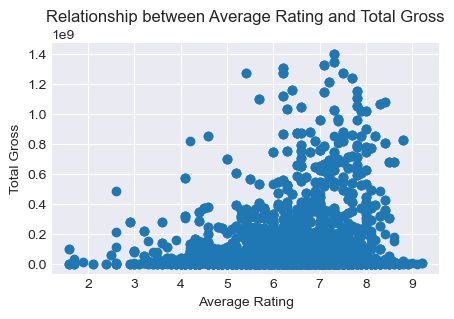

In [61]:
# visualizing the relationship with a scatterplot

fix, ax = plt.subplots(figsize=(5, 3))

ax.scatter(
    x=movies_ratings_gross['averagerating'],
    y=movies_ratings_gross['total_gross'])

ax.set_xlabel('Average Rating')
ax.set_ylabel('Total Gross')
ax.set_title('Relationship between Average Rating and Total Gross');

With this relatively weak positive correlation, what we can deduce is that **just because a movie makes money at the box office, doesn't mean it is well-received by audiences or critics**.

This is significant if we are considering which movies will be in high demand for streaming platforms after their theatrical run.

#### Relationship between `Average Rating` and `Vote Count`

In [62]:
# using NumPy to calculate Correlation Coefficient

print('Correlation between average rating and number of votes: {}'.format(
    np.corrcoef(
        movies_ratings_gross['numvotes'],
        movies_ratings_gross['averagerating'])[0,1]
))

Correlation between average rating and number of votes: 0.31837836436903144


This suggests a **relatively weak positive correlation** between the average rating and number of votes, as expected.

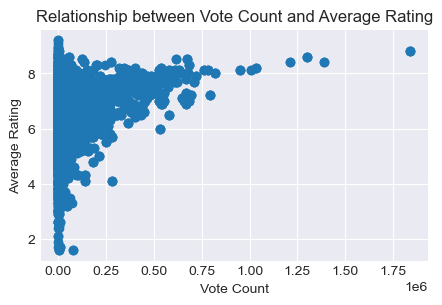

In [63]:
# visualizing the relationship with a scatterplot

fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(
    x=movies_ratings_gross['numvotes'],
    y=movies_ratings_gross['averagerating'])

ax.set_xlabel('Vote Count')
ax.set_ylabel('Average Rating')
ax.set_title('Relationship between Vote Count and Average Rating');

Though the correlation is relatively weaker, it is still a positive correlation, which tells us that in general a movie that is seen more and rated more, tends ot be received better by audiences and critics.

<div class="alert alert-block alert-success">

#### **In sum, these correlation metrics tell us the following:**

1. Movies with higher vote counts tend to have higher rates of total gross and average ratings.
2. Movies that are rated higher tend to gross more.

These findings are significant because they confirm that `Average Rating`, `Vote Count`, and `Total Gross` are useful metrics for measuring a movie's success.

### 5.c. Which `Genres` tend to perform the best?

Now we need to investigate which genres tend to perform the best in terms of `Total Gross`, `Vote Count`, and `Average Rating`.

We can start by creating a pivot table that pulls just the columns we need from our dataset.

In [68]:
# Creating a pivot table that tracks Total Gross, Ratings, and Vote Count by Genre of the top 25% of movies

pivot_genres_25 = pd.pivot_table(
    data=movies_top_25,
    values=['total_gross', 'averagerating','numvotes'],
    index='genres',
    aggfunc=np.mean
).sort_values(by='total_gross', ascending=False).reset_index()


pivot_genres_25 = pivot_genres_25.round(2)
pivot_genres_25.head(5)

,genres,averagerating,numvotes,total_gross
0,Animation,7.20,229980.20,6.045609e+08
1,Adventure,6.80,297638.84,4.727174e+08
2,Musical,7.60,199663.00,4.350000e+08
3,Sci-Fi,6.86,364545.41,4.103957e+08
4,Family,6.71,179190.92,3.627833e+08


In [69]:
# Creating two more pivot tables for Vote Count and Average Rating

pivot_vote_25 = pd.pivot_table(
    data=pivot_genres_25,
    values='numvotes',
    index='genres',
    aggfunc=np.mean
).sort_values(by='numvotes', ascending=False).reset_index()

pivot_rating_25 = pd.pivot_table(
    data=pivot_genres_25,
    values='averagerating',
    index='genres'
).sort_values(by='averagerating', ascending=False).reset_index()

In [70]:
pivot_vote_25.head(5)

,genres,numvotes
0,Western,466200.00
1,Sci-Fi,364545.41
2,Adventure,297638.84
3,Action,265417.13
4,Mystery,247498.60


Now that we have out pivot tables ready, let's visualize the `Average Rating by Genre` and `Average Vote Count by Genre`.

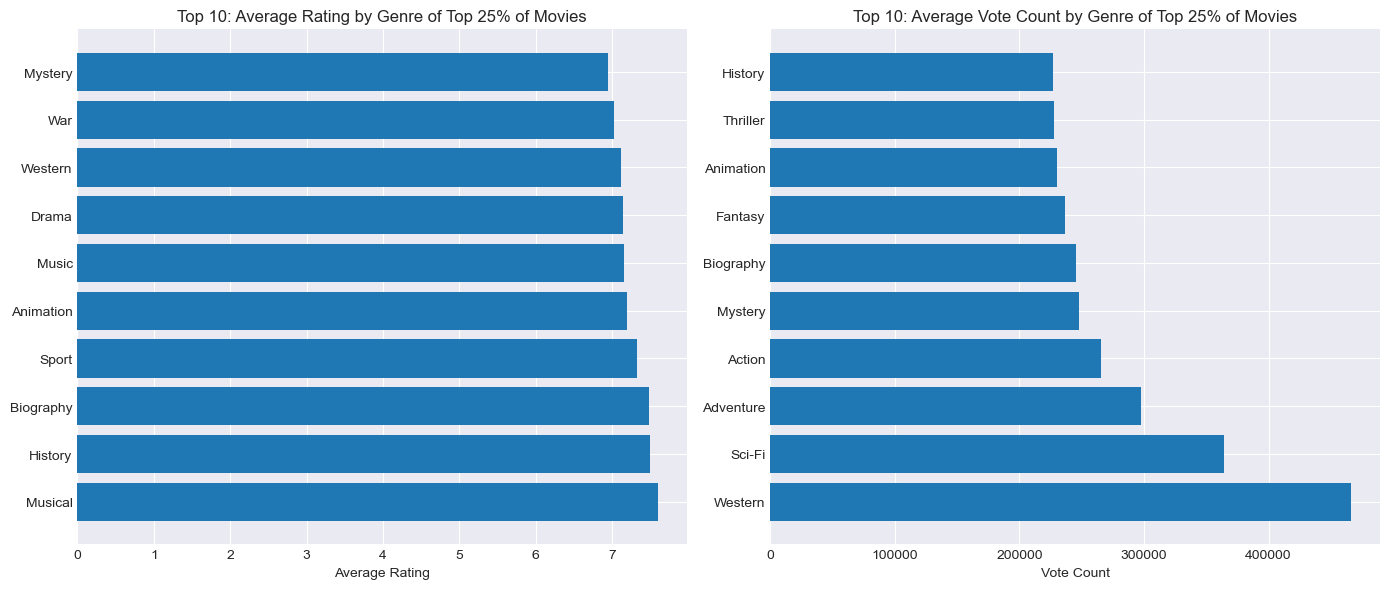

In [71]:
fig, (genre_rating, genre_vote) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

genre_rating.barh(
    y=pivot_rating_25['genres'].head(10),
    width=pivot_rating_25['averagerating'].head(10))
genre_rating.set_xlabel('Average Rating')
genre_rating.set_title('Top 10: Average Rating by Genre of Top 25% of Movies')

genre_vote.barh(
    y=pivot_vote_25['genres'].head(10),
    width=pivot_vote_25['numvotes'].head(10))
genre_vote.set_xlabel('Vote Count')
genre_vote.set_title('Top 10: Average Vote Count by Genre of Top 25% of Movies')

plt.tight_layout();

These first graph doesn't tell us too much, as there is little difference between the Average Ratings of the Top 10 Genres.

The second graph tells us that the following genres tend other have significantly higher vote counts:
1. `Western`
2. `Sci-Fi`
3. `Adventure`

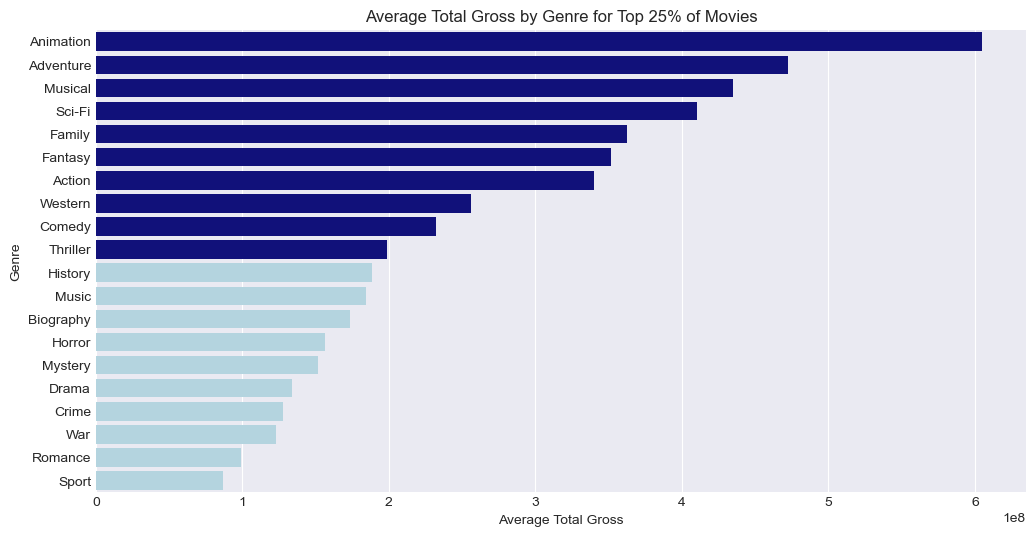

In [73]:
# Visualizing the average total gross by genres, with the top 10 genres indicated by Dark Blue

vals = pivot_genres_25['total_gross']
labels = pivot_genres_25['genres']

plt.figure(figsize=(12,6))

genres_gross_barplot = sns.barplot(
    x=vals,
    y=labels,
    orient='y',
    palette=['darkblue' if (x > vals[10]) else 'lightblue' for x in vals]

)

genres_gross_barplot.set(
    xlabel='Average Total Gross',
    ylabel='Genre',
    title='Average Total Gross by Genre for Top 25% of Movies');

<div class="alert alert-block alert-success">

#### It's interesting to note the following:

1. While `Western` movies had much higher rates of Vote Counts, they were only 8th in rates of highest gross. This could indicate that while `Western` movies are viewed by more people that feel compelled to provide ratings and reviews, they don't perform as well in theaters.


2. `Animation` movies tend to gross much higher than others, though they are not so significant when it comes to Average Rating.. This could indicate that most animated movies are marketed to children and thus do not translate very high to Average Rating, seeing as animated movies are still in the Top 10 for Vote Count. 

#### What about `movies_bottom_75`?

Let's look at the distributions for the bottom 75% of movies in terms of vote count. Looking at this dataset can help us determine which types of movies we should avoid creating.

In [74]:
# Creating a pivot table that tracks Total Gross, Ratings, and Vote Count by Genre of the bottom 75% of movies

pivot_genres_75 = pd.pivot_table(
    data=movies_bottom_75,
    values=['total_gross', 'averagerating','numvotes'],
    index='genres',
    aggfunc=np.mean
).sort_values(by='total_gross', ascending=False).reset_index()


pivot_genres_75 = pivot_genres_75.round(2)
pivot_genres_75.head(5)

,genres,averagerating,numvotes,total_gross
0,Animation,6.48,23085.67,1.046213e+08
1,Adventure,6.18,25452.19,8.392298e+07
2,Sport,6.77,20759.18,8.297422e+07
3,Family,6.09,15891.66,5.526257e+07
4,Sci-Fi,5.68,27849.78,5.458951e+07


In [75]:
# Creating two more pivot tables for Vote Count and Average Rating

pivot_vote_75 = pd.pivot_table(
    data=pivot_genres_75,
    values='numvotes',
    index='genres',
    aggfunc=np.mean
).sort_values(by='numvotes', ascending=False).reset_index()

pivot_rating_75 = pd.pivot_table(
    data=pivot_genres_75,
    values='averagerating',
    index='genres'
).sort_values(by='averagerating', ascending=False).reset_index()

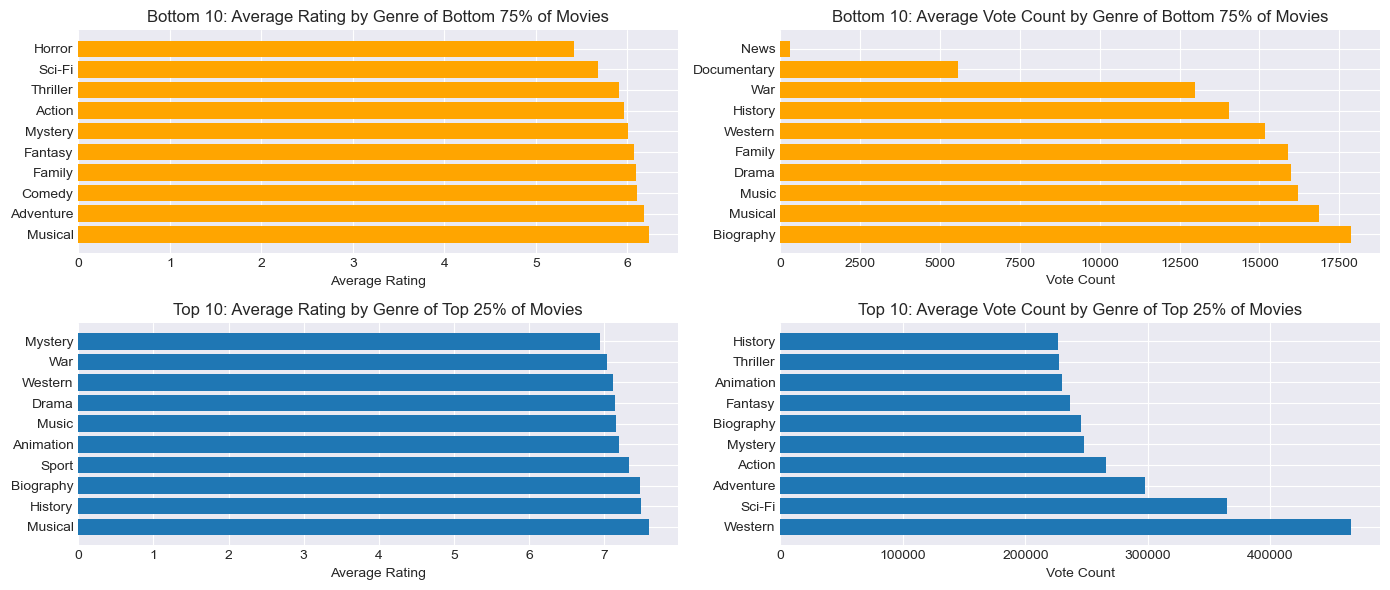

In [103]:
fig, ((genre_rating75, genre_vote75), (genre_rating25, genre_vote25)) = plt.subplots(
    nrows=2, ncols=2, figsize=(14, 6))

genre_rating75.barh(
    y=pivot_rating_75['genres'].tail(10),
    width=pivot_rating_75['averagerating'].tail(10), 
    color='orange')
genre_rating75.set_xlabel('Average Rating')
genre_rating75.set_title('Bottom 10: Average Rating by Genre of Bottom 75% of Movies')

genre_vote75.barh(
    y=pivot_vote_75['genres'].tail(10),
    width=pivot_vote_75['numvotes'].tail(10), 
    color='orange')
genre_vote75.set_xlabel('Vote Count')
genre_vote75.set_title('Bottom 10: Average Vote Count by Genre of Bottom 75% of Movies')


genre_rating25.barh(
    y=pivot_rating_25['genres'].head(10),
    width=pivot_rating_25['averagerating'].head(10))
genre_rating25.set_xlabel('Average Rating')
genre_rating25.set_title('Top 10: Average Rating by Genre of Top 25% of Movies')

genre_vote25.barh(
    y=pivot_vote_25['genres'].head(10),
    width=pivot_vote_25['numvotes'].head(10))
genre_vote25.set_xlabel('Vote Count')
genre_vote25.set_title('Top 10: Average Vote Count by Genre of Top 25% of Movies')

plt.tight_layout();

As we can see, the difference between the average rating of the Top 10 movies is negligible, less than one point. The difference in average rating for the Bottom 10 is likewise negligible, though it is of a slightly wider margin than the Top 10.

However, we do see a wide margin of difference between the average vote count of both the Top 10 and the Bottom 10 movies.

<div class="alert alert-block alert-success">

Here's what we can tell:
- While `Western` movies have the highest average vote count by far, their critical reception is not much different than other genres.
- `Sci Fi` movies have high average vote count, but are not present in the Top 10 for average rating.
- `News` and 'Documentary' movies have a starkly lower average vote count than any other genre in the Bottom 10.
- `Horror` movies have the lowest average rating of the Bottom 10 and is not present in the Top 10.

#### Now let's look at the `Average Total Gross by Genre`.

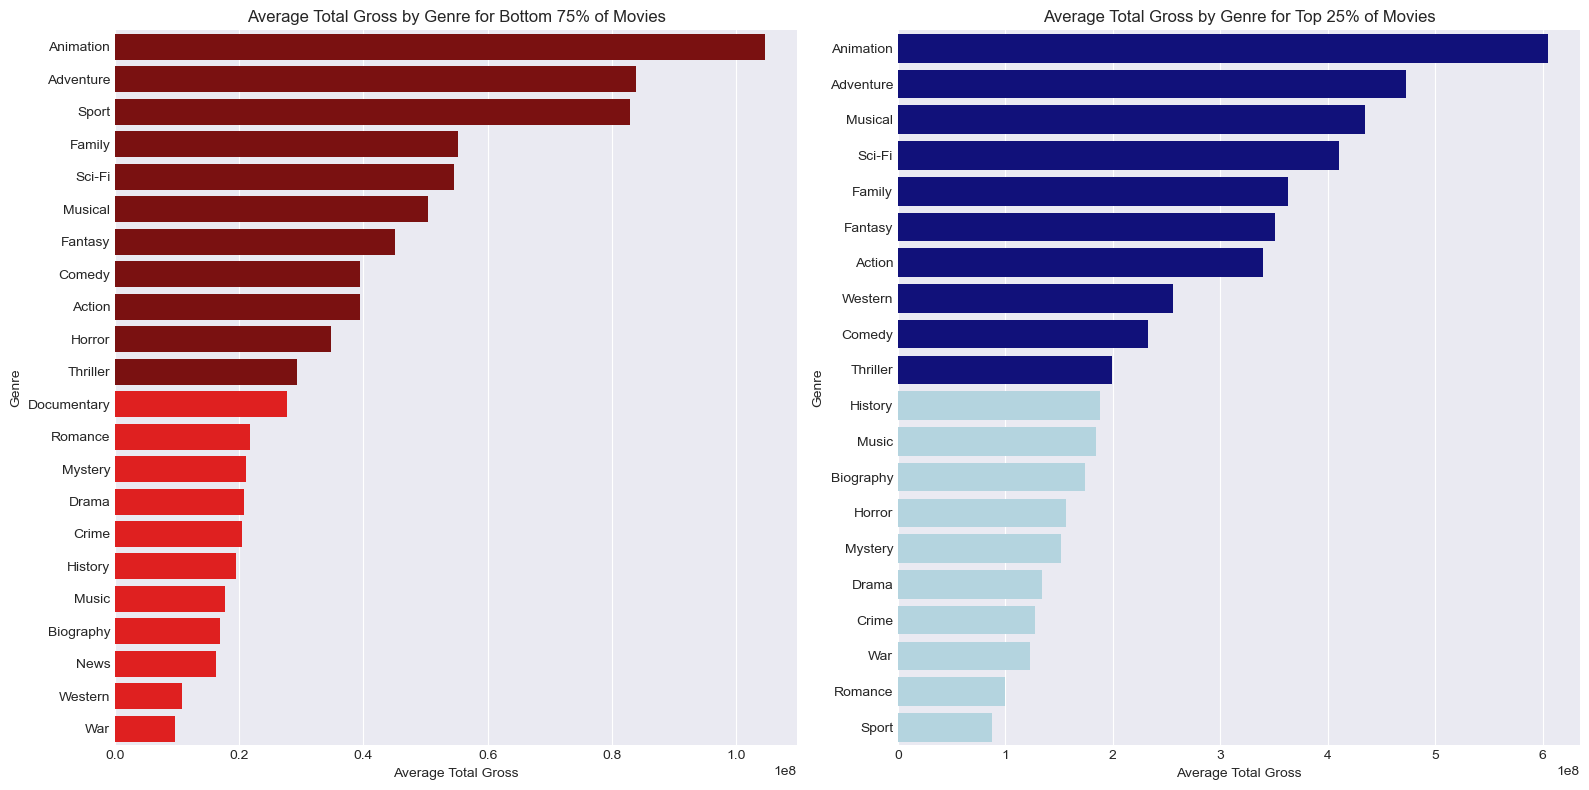

In [100]:
# Visualizing the average total gross by genres for both top 25% and bottom 75% of movies

vals_75 = pivot_genres_75['total_gross']
labels_75 = pivot_genres_75['genres']

vals_25 = pivot_genres_25['total_gross']
labels_25 = pivot_genres_25['genres']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

# Bottom 75% barplot
sns.barplot(
    x=vals_75,
    y=labels_75,
    orient='h',
    palette=['red' if (x < vals_75.median()) else 'darkred' for x in vals_75],
    ax=ax1
)
ax1.set(
    xlabel='Average Total Gross',
    ylabel='Genre',
    title='Average Total Gross by Genre for Bottom 75% of Movies'
)

# Top 25% barplot
sns.barplot(
    x=vals_25,
    y=labels_25,
    orient='h',
    palette=['darkblue' if (x > vals_25.median()) else 'lightblue' for x in vals_25],
    ax=ax2
)
ax2.set(
    xlabel='Average Total Gross',
    ylabel='Genre',
    title='Average Total Gross by Genre for Top 25% of Movies'
)

plt.tight_layout()
plt.show();


We can see that the genres with the highest average of total gross are:

1. `Animation`
2. `Adventure`
3. `Musical`
4. `Sci-Fi`
5. `Family`
6. `Fantasy`
7. `Action`
8. `Western`
9. `Comedy`
10. `Thriller`

We can also see that the poorest performing genres are:
1. `Documentary`
2. `Romance`
3. `Mystery`
4. `Drama`
5. `Crime`
6. `History`
7. `Music`
8. `Biography`
9. `News`
10. `Western`
11. `War`

Of course, there is some overlap between the two visualizations, such as `Western` being listed among the Top 10 of the Top 25% and also in the Bottom 10 of the Bottom 75%. This should not be too surprising as it is plausible that films such as Westerns can do really well if made really well, or perform very poorly if not made right, and this might indicate that making these films would be risky.

Instead, we should look at: 

<div class="alert alert-block alert-success">

1. #### Which genres are present in the poorest performing genres but absent from the best performing genres?
   - `Documentary`
   - `War`
   - `News`
   - `Crime`
   - `Romance`
   - `Mystery`
   - `Biography`
   - `Drama` <br><br>
2. #### Which genres are present in the highest performing genres of both Top 25% and Bottom 75%?
   - `Animation`
   - `Adventure`
   - `Sci-Fi`
   - `Musical`
   - `Family`
   - `Action`
   - `Fantasy`
   - `Comedy`
   - `Thriller`



## 6. Evaluation

### 6.a. Limitations

- **Did not look at closer data such as budget, director, cast.**

Though these factors could be useful in determining which directors are more likely to create a successful movie, which actors are more likely to draw audiences, and how much of a budget could be expected to produce a hit movie, in reality these factors are more difficult to account for and too unreliable (for example, it's not a guarantee that a certain budget can be acquired, or that desired directors or actors could be secured).

Since these factors lie alrgely outside the realm of our control, it's better to look at which types of movies perform well before considering details such as cast and director.

- **Did not factor in longevity or demand on streaming**

Unfortunately, streaming services tend to be generally tight-lipped about the performance of the products on their platforms. However, we can reasonably assume that movies that perform well at the box office and also garner a wide audience would be sought after by streaming platforms.
 
- **Did not look at role of discourse, social media buzz, word of mouth, etc.**

As these matters are largely outside the realm of our inquiry, and more difficult to ascertain to a definitive degree as opposed to hard numbers such as gross and critical reception, we were unable to factor these into our assessment, though we can also reasonably assume that movies that perform well and are widely viewed would correlate to higher degrees of online discourse and social media buzz.

### 6.b. Our Factors and Metrics

To reiterate, we looked at the relationship between genres and three main metrics (gross, rating, vote count) as they provide insight in the following ways:

1. *Average Gross*: This indicates a movie's performance at the box office and perhaps the most immediate and tangible form of return on investment. However, as is often the case, a movie may perform well in theaters despite being poorly received by audience and/or critics, so looking only at this factor would limit our insight.
2. *Average Rating*: This metric helps us ascertain how well-received a movie was among audiences and critics, which can be a good indicator in considering the overall quality of a movie. However, this does not account for the fact that movies can be well-received by a tiny audience or gain a cult-following, and just because a movie has a high rating does not necessarily mean it was viewed widely or performed well at the box office.
3. *Average Vote Count*: With this we are able to get a general sense of how widely-viewed or widely-engaged the movie was, as movie with a high vote indicates that it was more widely viewed, and also that those that viewed it were more motivated to provide a rating, whether positive or negative. However, this does not indicate to us a movie's success, as movies that were derided by audiences or received negatively by critics would also have high vote counts.

Taking these three metrics in conjunction with each other gives us a fuller picture as to which genres pull audiences into theaters, are generally well-received by audiences and critics, and which are widely viewed. In the age of streaming, and despite the fluctuations in the streaming industry, we can reasonably assume that a movie that would perform well in 2 or 3 of these metric categories would be sought after by streaming companies.

Despite these limitations, we have been able to identify **which genres tend to perform the best at the box office, attract the widest audience, and are best received on average by audiences and critics,** which will be outlined in our recommendations below.

### 6.b. Which movies are best received by audiences and critics, have the highest vote counts, and the highest average ratings?

The analysis we conducted gave us three different lists:
1. Highest Grossing Genres
2. Genres with the Highest Ratings
3. Genres with the Highest Vote Counts

Let's take a closer look at the overlap between these lists:

<div class="alert alert-block alert-success">

| Highest Gross & Vote Count | Highest Gross & Rating | Highest Rating & Vote Count |
|:--------:|:--------:|:--------:|
|   Sci-Fi  |  Musical   |  History   |
|  Adventure   |  Animation   |  Biography   |
|  Animation   |  -   |  Animation   |
|  Action   |   -  |  Western   |
|  Fantasy   |  -   |  Mystery   |
|  Thriller   |  -   |  -    |

It is interesting to note that `Animation` is the only genre that overlaps across all three of those list of metrics, indicating it is the only genre that is among the highest grossing, highets rated, and has the highest vote count.

## 7. Recommendations

Based on the insights gained from the analysis above, where we looked at which genres of movies had the highest vote counts on IMDB, the highest ratings, and the highest gross, as well as which genres generally had poor records in those three categories, we're able to confidently provide three recommendations. Despite the limitations outlined, these recommendations are strong starting points to consider before moving into the details around budget, cast, director, etc.

### 1. Invest in `Animation`

Seeing as how the `Animation` genre was among the highest performing genres across all three factors (gross, average rating, average vote count), in addition to the fact that it was the only genre to be present across all three lists numerating the overlapping genres across those three factors (Highest Gross & Vote Count, Highest Gross & Rating, Highest Vote Count & Rating), **we can confidently recommend investing in `Animation` as a genre that is most likely to draw large audiences, perform well in theaters, and be well-received by audiences and critics.** In other words, it is the only genre we found to be all but guaranteed to both perform highly at the box office and garner a reputation that would predictably put it in high demand among streaming platforms.

### 2. Other genres to invest in

The vast majority of the movies analyzed included multiple genres. In considering the three factors we investigated (gross, rating, and vote count), the following genres had the highest recurrence, indicating they are safe bets as far as investments, and **we recommend investing in some combination of 2-3 of the following genres, or combining 1-2 of the following genres with `Animation`:**

1. `Adventure`
2. `Sci-Fi`
3. `Musical`
4. `Family`
5. `Action`
6. `Fantasy`
7. `Comedy`
8. `Thriller`

### 3. Genres to avoid

The analysis also helped us identify genres that performed poorly generally speaking according to our three metrics. It should be said that this is not an indictment of these genres overall, as we did see the genres present to varying degrees among the well-performing ones. However, their recurrence among the `Bottom 10 Genres` would at least indicate that investment in films of the following genres at best would be risky, as for example `Horror` movies can at times perform extremely well, but it is also very easy to go wrong with those movies. 

For this reason, **we recommend avoiding investment in the following genres**:

1. `Documentary`
2. `War`
3. `News`
4. `Crime`
5. `Romance`
6. `Biography`
7. `Horror`